## Train Faster R-CNN model on dentex image data ##

Model description for the "faster_rcnn_R_101_FPN_3x" model:

https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md

Weights configuration file: 

https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml

This notebooks requires the detectron2 library.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt
from pathlib import Path

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# PyTorch libraries
import torch

# Detectron2 library
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.detector import Trainer

print(f'Project module version: {dm.__version__}')
print(f'Detectron2 version:     {detectron2.__version__}')

Project module version: 0.0.post1.dev163+g9fa083d.d20240224
Detectron2 version:     0.6


In [2]:
# GPU checks
is_cuda = torch.cuda.is_available()
print(f'CUDA available: {is_cuda}')
print(f'Number of GPUs found:  {torch.cuda.device_count()}')

if is_cuda:
    print(f'Current device ID:     {torch.cuda.current_device()}')
    print(f'GPU device name:       {torch.cuda.get_device_name(0)}')
    print(f'CUDNN version:         {torch.backends.cudnn.version()}')
    device_str = 'cuda:0'
    torch.cuda.empty_cache() 
else:
    device_str = 'cpu'
device = torch.device(device_str)
print()
print(f'Device for model training/inference: {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID:     0
GPU device name:       NVIDIA GeForce RTX 3070 Laptop GPU
CUDNN version:         8902

Device for model training/inference: cuda:0


In [3]:
# Path settings 
# Main data directory (defined as environment variable in docker-compose.yml)
data_root = os.environ.get('DATA_ROOT')

# Download directory (change as needed)
dentex_dir = os.path.join(data_root, 'dentex')
model_dir = os.path.join(data_root, 'model')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Directory for the output
output_dir = os.path.join(data_dir, 'output')

# Data frame with data splits 
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(data_dir, data_df_file_name)

In [4]:
# Annotation files (and make sure the files are where they should be.
annotation_files = {}
dataset_list = ['train', 'val', 'test']
annotation_name_list = [f'dentex_detection_{dataset}.json' for dataset in dataset_list]
annotation_file_list = [os.path.join(data_dir, file_name) for file_name in annotation_name_list]
annotation_file_dict = dict(zip(dataset_list, annotation_file_list))
for dataset, annotation_file in annotation_file_dict.items():
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f'Annotation "{json_file}" not found.')
    else:
        annotation_files.update({dataset: annotation_file})
display(annotation_files)

{'train': '/app/data/dentex/dentex_detection/dentex_detection_train.json',
 'val': '/app/data/dentex/dentex_detection/dentex_detection_val.json',
 'test': '/app/data/dentex/dentex_detection/dentex_detection_test.json'}

### Register the dentex datasets ####

In [5]:
annotation_dict = {}
for dataset, annotation_file in annotation_file_dict.items():
    try:
        with open(annotation_file, 'r') as fl:
            annotations = json.load(fl)
    except FileNotFoundError:
        print(f'Annotation file not found: {annotation_file}')
        print('Make sure to run the annotations notebook.')
    else:
        annotation_dict.update({dataset: annotations})
        print(f'Loaded annotations for {len(annotations)} images for dataset "{dataset}".')

# Register the data sets
for dataset in dataset_list:
    dataset_name = f'dentex_{dataset}'
    if dataset_name not in DatasetCatalog:
        DatasetCatalog.register(name=dataset_name, func=lambda d=dataset: annotation_dict.get(d))
        MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])

Loaded annotations for 534 images for dataset "train".
Loaded annotations for 50 images for dataset "val".
Loaded annotations for 50 images for dataset "test".


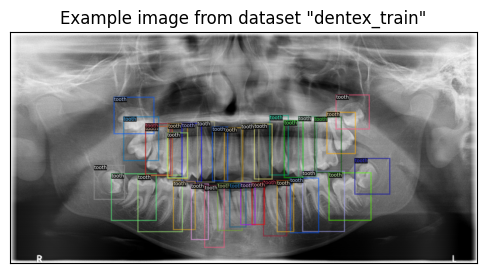

In [6]:
# Plot one image from the training set
def show_image(image, figsize=(3, 3), title=''):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.set_title(title)
    ax.set(xticks=[], yticks=[])
    return fig, ax

# Load one random image from the training set
dataset = 'dentex_train'
image_list = DatasetCatalog.get(dataset)
image_dict = np.random.choice(image_list, size=1)[0]
metadata = MetadataCatalog.get(dataset)
im = ImageData().load_image(image_dict.get('file_name'))
vs = Visualizer(img_rgb=im, metadata=metadata, scale = 1.0)
vs = vs.draw_dataset_dict(image_dict).get_image()
fig, ax = show_image(vs, figsize=(12, 3), title=f'Example image from dataset "{dataset}"')
plt.show()

### Configure Faster R-CNN model for training ###

In [7]:
# Model definition
# For a description, see https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
# https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml
model_config = os.path.join('COCO-Detection', 'faster_rcnn_R_101_FPN_3x.yaml')

# Build configuration file
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_config))

# Output directory
model_name = 'Toothdetector'
model_version = 1
model_output_dir = os.path.join(model_dir, model_name, f'version_{model_version}')
Path(model_output_dir).mkdir(parents=True, exist_ok=True)

# Set the names for the datasets (as registered)
cfg.DATASETS.TRAIN = ('dentex_train', )
cfg.DATASETS.TEST = ('dentex_val', )
cfg.TEST.EVAL_PERIOD = 100
# The numbers of workers you can use depends on the number of cores and memory available per core
# Four workes is good for 32G memory
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)
# The batch size needs to be adjusted according to the GPU memory
# A batch size of 4 works for and 8 GB GPU
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = []
# Train for at least 3,000 iterations to get good results
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = model_output_dir

# Train on GPU or CPU
cfg.MODEL.DEVICE = device.type

# Save the config file before training
model_config_file_name = f'{model_name}_{model_version}_config.yml'
model_config_file = os.path.join(model_output_dir, model_config_file_name)
with open(model_config_file, mode='w') as fl:
    fl.write(cfg.dump())

In [8]:
# Train the model
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[02/25 15:45:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[02/25 15:45:17 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/25 15:45:31 d2.utils.events]:  eta: 0:10:09  iter: 19  total_loss: 4.491  loss_cls: 0.7791  loss_box_reg: 0.5851  loss_rpn_cls: 2.812  loss_rpn_loc: 0.2741    time: 0.6256  last_time: 0.6102  data_time: 0.0205  last_data_time: 0.0050   lr: 4.9953e-06  max_mem: 5369M


2024-02-25 15:45:31.423582: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 15:45:31.423606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 15:45:31.424337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 15:45:31.429201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 15:45:32.241327: W tensorflow/compiler/tf2

[02/25 15:45:45 d2.utils.events]:  eta: 0:09:52  iter: 39  total_loss: 2.09  loss_cls: 0.7465  loss_box_reg: 0.8402  loss_rpn_cls: 0.2561  loss_rpn_loc: 0.2337    time: 0.6189  last_time: 0.6248  data_time: 0.0051  last_data_time: 0.0050   lr: 9.9902e-06  max_mem: 5369M
[02/25 15:45:57 d2.utils.events]:  eta: 0:09:43  iter: 59  total_loss: 1.845  loss_cls: 0.6869  loss_box_reg: 0.8508  loss_rpn_cls: 0.08875  loss_rpn_loc: 0.2226    time: 0.6218  last_time: 0.5914  data_time: 0.0053  last_data_time: 0.0048   lr: 1.4985e-05  max_mem: 5369M
[02/25 15:46:10 d2.utils.events]:  eta: 0:09:29  iter: 79  total_loss: 1.761  loss_cls: 0.6259  loss_box_reg: 0.8458  loss_rpn_cls: 0.07138  loss_rpn_loc: 0.2095    time: 0.6219  last_time: 0.5918  data_time: 0.0052  last_data_time: 0.0047   lr: 1.998e-05  max_mem: 5369M
[02/25 15:46:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/2